# Word Embeddings Analysis with GloVe 🔤

## TC 3007B - Activity 1

### Team Members

- [Carlos Salguero](https://github.com/salgue441)

## 📚 Overview

This notebook explores word embeddings using GloVe (Global Vectors for Word Representation) to understand semantic relationships between words. We'll implement various techniques to visualize and analyze the embeddings, such as t-SNE and PCA.

## Assignment Objectives ✅

1. Understanding word embeddings in NLP
2. Implementing dimensionality reduction (PCA and t-SNE) to visualize embeddings
3. Creating word similarity and analogy functions
4. Visualizing high-dimensional embeddings data


## 🛠️ Setup & Configuration

First, we'll import the necessary libraries and set up our configuration.


In [76]:
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pickle
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple, Optional, Union
from dataclasses import dataclass
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

### Configuration Settings


In [77]:
plt.style.use("ggplot")
sns.set_palette("tab10")

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Embedding Class


In [79]:
@dataclass
class EmbeddingConfig:
    path: Path
    dim: int = 50
    cache_path: Path = Path("cache")
    use_cache: bool = True
    case_sensitive: bool = False

    def __post_init__(self):
        self.cache_path.mkdir(exist_ok=True)

        if not self.path.exists():
            raise FileNotFoundError(f"Embedding file not found: {self.path}")

## Embedding Class

The following class handles:

- Loading and caching embeddings
- Word similarity calculations
- Analogy computations
- Visualization of embeddings


In [80]:
class Embeddings:
    def __init__(self, config: Optional[EmbeddingConfig] = None):
        self.config = config
        self.embeddings: Dict[str, torch.Tensor] = {}

    def load_embedding(self):
        """
        Loads the embeddings from the file path specified in the config.

        Raises:
            FileNotFoundError: If the file is not found.
        """

        cache_file = self.config.cache_path / f"embeddings_{self.config.dim}d.pt"

        if self.config.use_cache and cache_file.exists():
            self.embeddings = torch.load(cache_file)
            return

        with open(self.config.path, "r", encoding="utf-8") as file:
            for line in tqdm(file, desc="Processing embeddings"):
                values = line.split()
                word = values[0]

                if not self.config.case_sensitive:
                    word = word.lower()

                try:
                    vector = torch.tensor(
                        [float(value) for value in values[1:]],
                        dtype=torch.float32,
                        device=device,
                    )

                    self.embeddings[word] = F.normalize(vector, p=2, dim=0)

                except Exception as e:
                    print(f"Error: {e}")

        if self.config.use_cache:
            torch.save(self.embeddings, cache_file)

    def get_embedding(self, word: str) -> Optional[torch.Tensor]:
        """
        Get the embedding for a word.

        Args:
            word (str): The word to get the embedding for.

        Returns:
            Optional[torch.Tensor]: The embedding for the word if it exists, else None.
        """
        word = word.lower() if not self.config.case_sensitive else word
        return self.embeddings.get(word)

    def find_most_similar(self, word: str, top_n: int = 10) -> List[Tuple[str, float]]:
        """
        Finds the most similar words to the given word based on cosine
        similarity.

        Args:
            word (str): The word to find similar words for.
            top_n (int, optional): The number of similar words to return. Defaults to 10.

        Returns:
            List[Tuple[str, float]]: The list of similar words and their cosine similarity.

        Raises:
            KeyError: If the word is not found in the embeddings.
        """

        word_embedding = self.get_embedding(word)
        if word_embedding is None:
            raise KeyError(f"Word not found in embeddings: {word}")

        words = list(self.embeddings.keys())
        embeddings = torch.stack(list(self.embeddings.values()))

        with torch.inference_mode():
            similarities = F.cosine_similarity(
                word_embedding.unsqueeze(0), embeddings, dim=1
            )

        top_similarities, top_indices = similarities.topk(top_n + 1)
        results = [
            (words[idx], sim.item())
            for idx, sim in zip(top_indices, top_similarities)
            if words[idx] != word
        ][:top_n]

        return results

    def compute_analogy(
        self, word1: str, word2: str, word3: str, top_n: int = 5
    ) -> List[Tuple[str, float]]:
        """
        Computes the analogy words for the given words. It finds the word
        based on the analogy: word2 - word1 + word3.

        Args:
            word1 (str): The first word.
            word2 (str): The second word.
            word3 (str): The third word.
            top_n (int, optional): The number of analogy words to return. Defaults to 5.

        Returns:
            List[Tuple[str, float]]: The list of analogy words and their cosine similarity.
        """

        embs = [self.get_embedding(word) for word in (word1, word2, word3)]
        if None in embs:
            missing = [w for w, e in zip([word1, word2, word3], embs) if e is None]

            raise KeyError(f"Word(s) not found in embeddings: {missing}")

        with torch.inference_mode():
            target = embs[1] - embs[0] + embs[2]
            target = F.normalize(target, p=2, dim=0)

            words = list(self.embeddings.keys())
            embeddings = torch.stack(list(self.embeddings.values()))
            similarities = F.cosine_similarity(target.unsqueeze(0), embeddings)

            top_similarities, top_indices = similarities.topk(top_n)
            results = [
                (words[idx], sim.item())
                for idx, sim in zip(top_indices, top_similarities)
                if words[idx] not in [word1, word2, word3]
            ][:top_n]

        return results

    def visualize_embeddings(
        self,
        words: List[str],
        method: str = "tsne",
        figsize: Tuple[int, int] = (10, 10),
    ):
        valid_words, embedding_list = [], []
        for word in words:
            emb = self.get_embedding(word)

            if emb is not None:
                valid_words.append(word)
                embedding_list.append(emb.cpu())

            else:
                print(f"Warning: '{word}' not found in vocabulary")

        if not embedding_list:
            raise ValueError("No valid words found in embeddings")

        embeddings_array = np.stack(embedding_list)
        reducer = (
            TSNE(n_components=2, perplexity=min(30, len(valid_words) - 1))
            if method.lower() == "tsne"
            else PCA(n_components=2)
        )

        reduced = reducer.fit_transform(embeddings_array)
        plt.figure(figsize=figsize)
        scatter = plt.scatter(
            reduced[:, 0],
            reduced[:, 1],
            c=range(len(valid_words)),
            cmap="viridis",
            alpha=0.6,
        )

        for i, word in enumerate(valid_words):
            plt.annotate(
                word,
                (reduced[i, 0], reduced[i, 1]),
                xytext=(5, 5),
                textcoords="offset points",
                fontsize=10,
                alpha=0.8,
            )

        plt.title(f"Word Embeddings ({method.upper()})")
        plt.colorbar(scatter, label="Word Index")
        plt.tight_layout()
        plt.show()

    def create_similarity_matrix(
        self, words: List[str], include_scores: bool = False
    ) -> Tuple[torch.Tensor, List[str]]:
        """
        Creates a similarity matrix for the given words.

        Args:
            words (List[str]): The words to create the similarity matrix for.
            include_scores (bool, optional): Whether to include the similarity scores in the matrix. Defaults to False.

        Returns:
            Tuple[torch.Tensor, List[str]]: The similarity matrix and the list of words.

        Raises:
            ValueError: If no valid words are found in the embeddings
        """
        valid_pairs = [(word, self.get_embedding(word)) for word in words]
        valid_words = [word for word, emb in valid_pairs if emb is not None]
        valid_embeddings = [emb for _, emb in valid_pairs if emb is not None]

        if not valid_embeddings:
            raise ValueError("No valid words found in embeddings")

        embeddings_tensor = torch.stack(valid_embeddings)
        with torch.inference_mode():
            embeddings_normalized = F.normalize(embeddings_tensor, p=2, dim=1)
            similarity_matrix = torch.mm(embeddings_normalized, embeddings_normalized.T)

        return similarity_matrix, valid_words

    def plot_similarity_matrix(
        self,
        words: List[str],
        figsize: Tuple[int, int] = (12, 10),
        cmap: str = "RdYlBu",
        annot: bool = True,
    ) -> None:
        """
        Create and plot a similarity matrix heatmap

        Args:
            words: List of words to compare
            figsize: Figure size
            cmap: Colormap to use
            annot: Whether to annotate cells with numerical value
        """
        similarity_matrix, valid_words = self.create_similarity_matrix(words)

        plt.figure(figsize=figsize)
        sns.heatmap(
            similarity_matrix.cpu().numpy(),
            xticklabels=valid_words,
            yticklabels=valid_words,
            cmap=cmap,
            annot=annot,
            fmt=".2f",
            square=True,
            center=0,
            vmin=-1,
            vmax=1,
            cbar_kws={"label": "Cosine Similarity"},
        )

        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)

        plt.title("Word Similarity Matrix")
        plt.tight_layout()
        plt.show()

    def plot_similiratiy_dendogram(
        self,
        words: List[str],
        figsize: Tuple[int, int] = (15, 10),
        method: str = "ward",
        metric: str = "euclidean",
    ):
        """
        Create a dendogram based on the similarity matrix

        Args:
            words (List[str]): List of words to compare
            figsize (Tuple[int, int], optional): Figure size. Defaults to (15, 10).
            method (str, optional): The linkage method to use. Defaults to "ward".
            metric (str, optional): The distance metric to use. Defaults to "euclidean".
        """

        similarity_matrix, valid_words = self.create_similarity_matrix(words)
        distances = 1 - similarity_matrix.cpu().numpy()
        linkage_matrix = sch.linkage(distances, method=method, metric=metric)

        plt.figure(figsize=figsize)
        sch.dendrogram(
            linkage_matrix, labels=valid_words, leaf_rotation=90, leaf_font_size=10
        )

        plt.title("Word Similarity Dendogram")
        plt.xlabel("Words")
        plt.ylabel("Distance")
        plt.tight_layout()
        plt.show()

## Main Execution


In [81]:
config = EmbeddingConfig(path=Path("data/glove.6B.50d.txt"), dim=50)

In [82]:
embedding_manager = Embeddings(config)
embedding_manager.load_embedding()

/tmp/ipykernel_13766/4075934375.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.embeddings = torch.load(cache_file)


### Similary Matrix


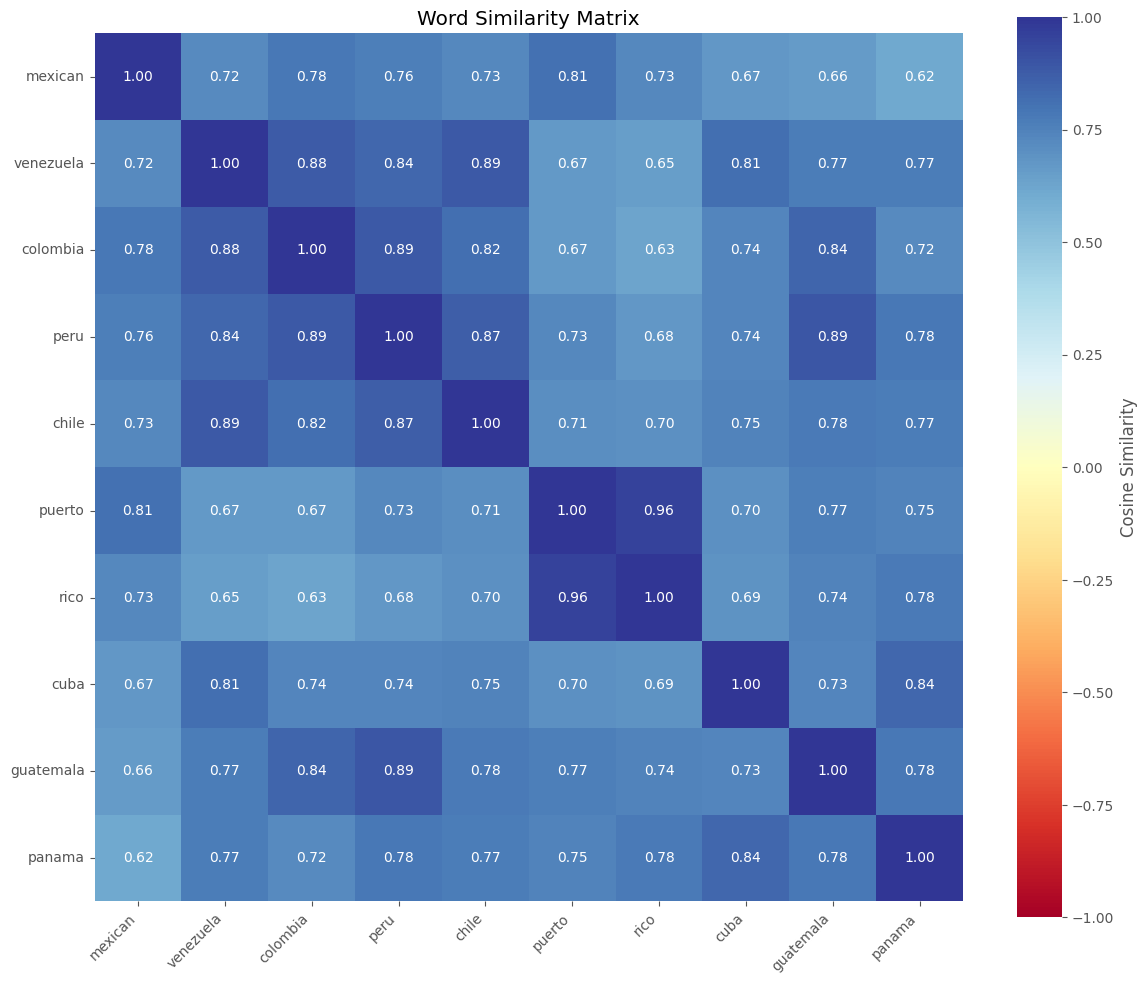

In [83]:
similar_words = embedding_manager.find_most_similar("mexico", top_n=10)
embedding_manager.plot_similarity_matrix([word for word, _ in similar_words])

### Analogy Task


In [84]:
analogy_results = embedding_manager.compute_analogy("man", "king", "woman", top_n=5)

print("\nAnalogy results for 'man:king::woman:?':")
for i, (word, score) in enumerate(analogy_results, 1):
    print(f"{i}. {word}: {score:.4f}")


Analogy results for 'man:king::woman:?':
1. queen: 0.8524
2. throne: 0.7664
3. prince: 0.7592
4. daughter: 0.7474


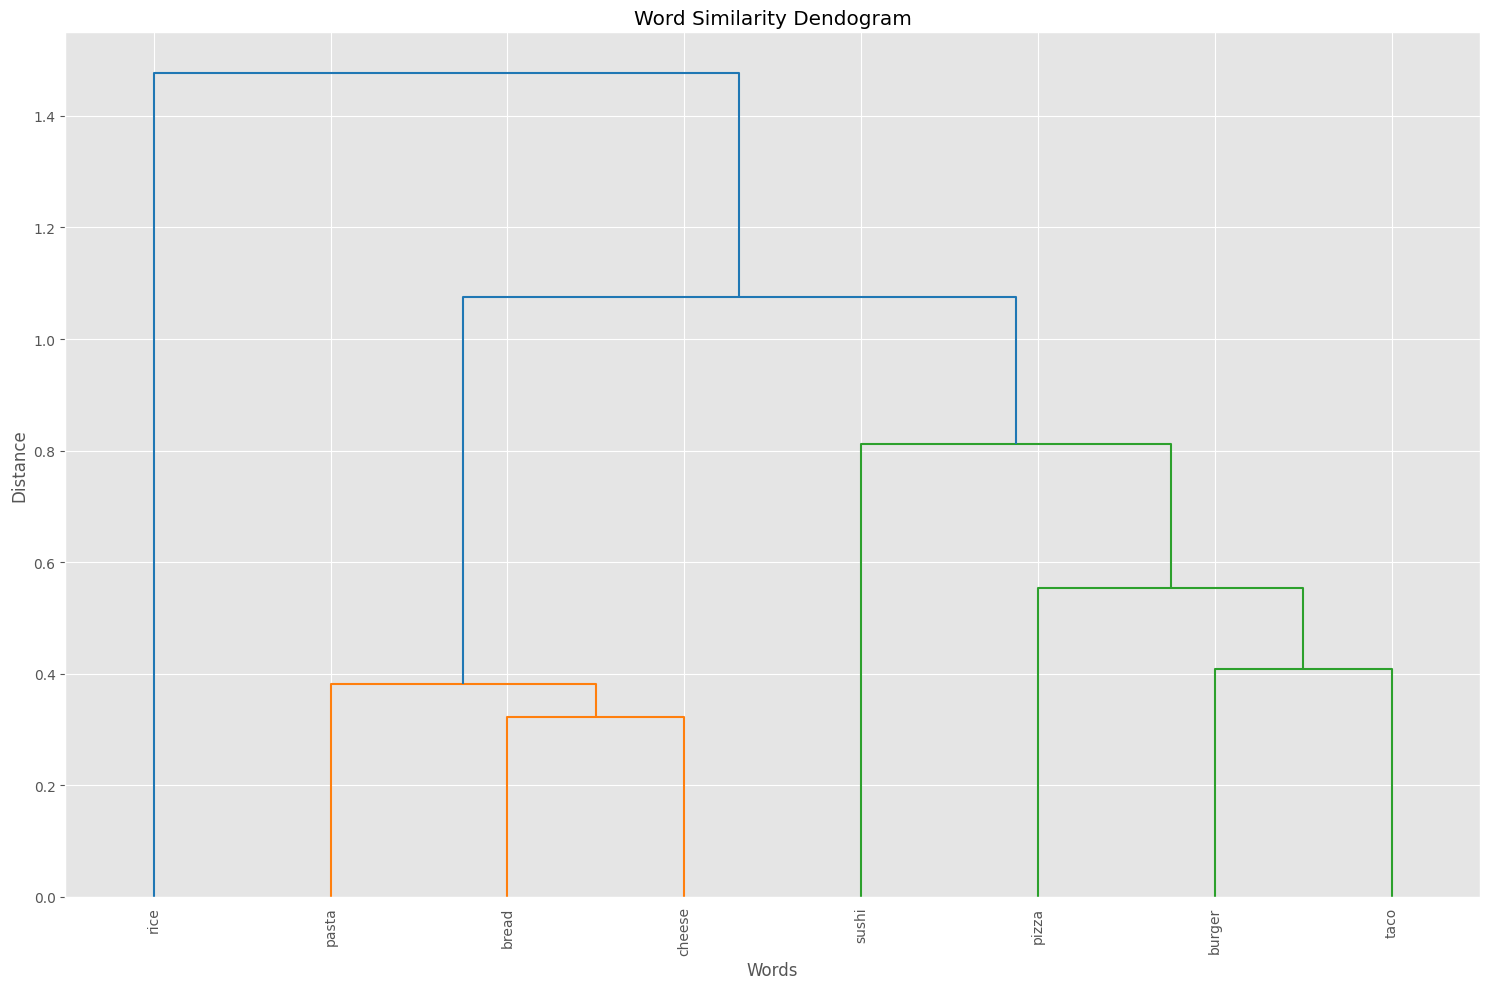

In [85]:
food_words = ["burger", "pizza", "pasta", "sushi", "taco", "rice", "bread", "cheese"]
embedding_manager.plot_similiratiy_dendogram(food_words)

### 🔍 Dimensionality Reduction

Word relationship visualization in 2D space using t-SNE and PCA.


In [86]:
test_words = [
    "burger",
    "tortilla",
    "bread",
    "pizza",
    "beef",
    "steak",
    "fries",
    "chips",
    "argentina",
    "mexico",
    "spain",
    "usa",
    "france",
    "italy",
    "greece",
    "china",
    "water",
    "beer",
    "tequila",
    "wine",
    "whisky",
    "brandy",
    "vodka",
    "coffee",
    "tea",
    "apple",
    "banana",
    "orange",
    "lemon",
    "grapefruit",
    "grape",
    "strawberry",
    "raspberry",
    "school",
    "work",
    "university",
    "highschool",
]

#### t-SNE Visualization

t-SNE helps us visualize high-dimensional data by preserving local structure


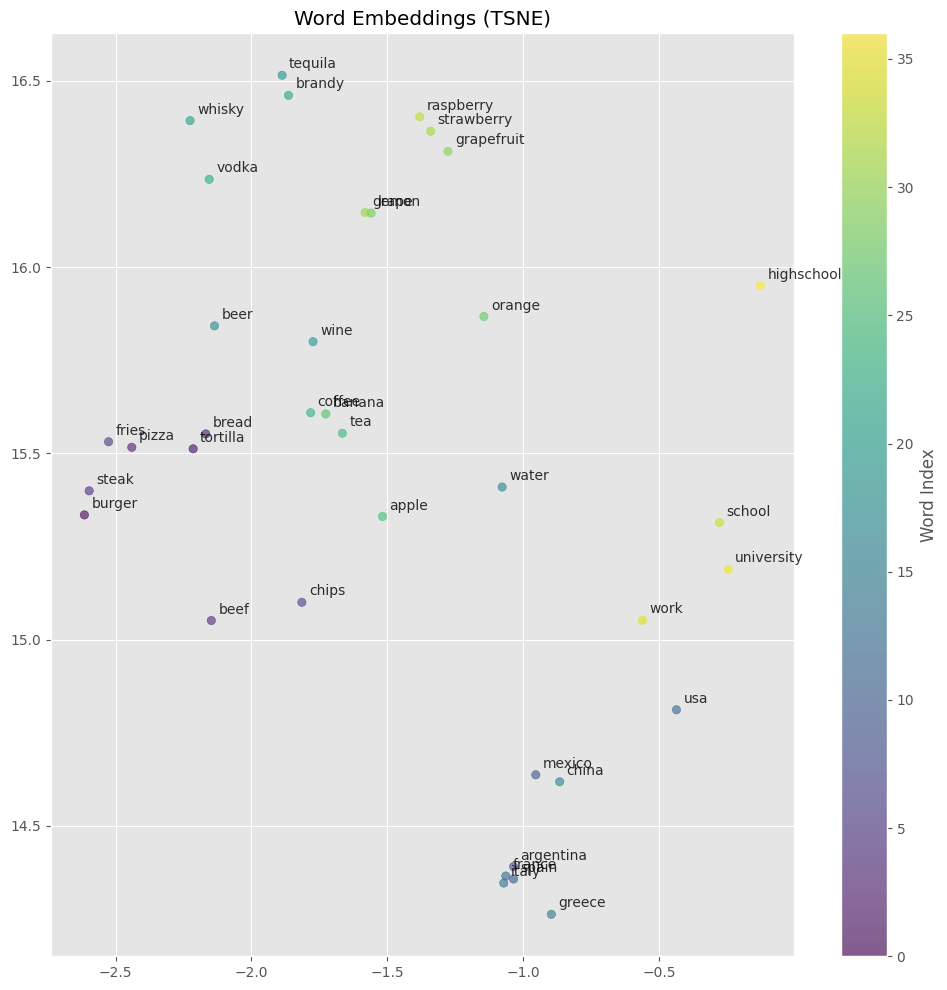

In [87]:
embedding_manager.visualize_embeddings(test_words, method="tsne")

### PCA


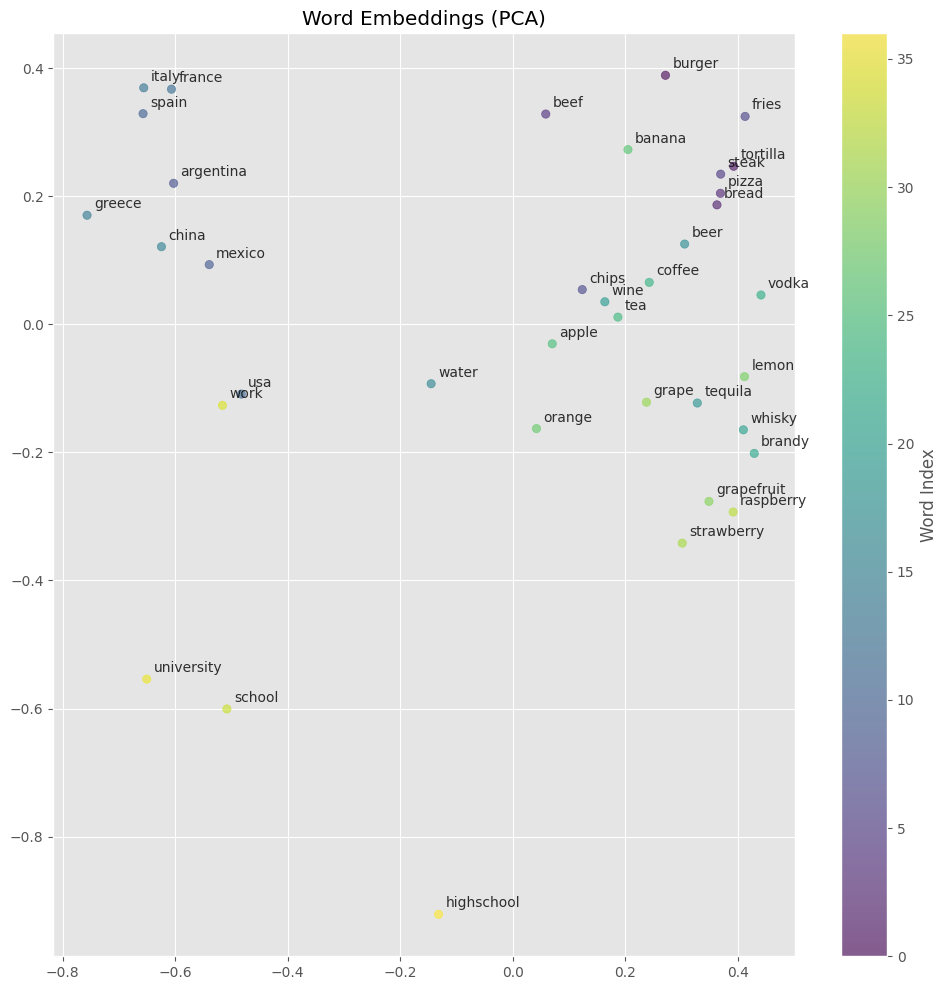

In [88]:
embedding_manager.visualize_embeddings(test_words, method="pca")